In [3]:
%matplotlib inline
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [7]:
image_file_name = 'page11.jpg' 
image = cv2.imread(image_file_name)

# gray convertion
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

abs_grad_x = cv2.convertScaleAbs(grad_x)
abs_grad_y = cv2.convertScaleAbs(grad_y)

# threshold
thresh_x = cv2.threshold(abs_grad_x, 0, 255,  cv2.THRESH_OTSU)[1]
thresh_y = cv2.threshold(abs_grad_y, 0, 255,  cv2.THRESH_OTSU)[1]

# bluring 
kernel_size = 3
blur_thresh_x = cv2.GaussianBlur(thresh_x,(kernel_size, kernel_size),0)
blur_thresh_y = cv2.GaussianBlur(thresh_y,(kernel_size, kernel_size),0)

# Run Hough on edge detected image

rho = 1  # distance resolution in pixels of the Hough grid   
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)  
min_line_length = 200  # minimum number of pixels making up a line   
max_line_gap = 1  # maximum gap in pixels between connectable line segments   
line_image = np.copy(gray) * 0  # creating a blank to draw lines on

# Vertical lines
vertical_lines = cv2.HoughLinesP(blur_thresh_x, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

if vertical_lines is not None:
    for line in vertical_lines:
        for x1,y1,x2,y2 in line:
            # here it's possible to add a selection of only vertical lines
            if np.abs(y1-y2)> 0.1 * np.abs(x1-x2):
                cv2.line(line_image,(x1,y1),(x2,y2),255,5)
                
                
                

# Horizontal lines
horizontal_lines = cv2.HoughLinesP(blur_thresh_y, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

if horizontal_lines is not None:
    for line in horizontal_lines:
        for x1,y1,x2,y2 in line:
            # here it's possible to add a selection of only horizontal lines
            if np.abs(x1-x2)> 0.1 * np.abs(y1-y2):
                cv2.line(line_image,(x1,y1),(x2,y2),255,5)   

In [8]:
# threshold
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# remove lines
clean_thresh = cv2.subtract(thresh, line_image)


In [9]:
# search the phrases
dilatation_type = cv2.MORPH_RECT
horizontal_dilatation = 20 #This is the gap. 20 for the first image, 10 for the second image
vertical_dilatation = 1
element = cv2.getStructuringElement(dilatation_type, (2*horizontal_dilatation + 1, 2*vertical_dilatation+1), (horizontal_dilatation, vertical_dilatation))
dilatation_thresh = cv2.dilate(clean_thresh, element)

# Fill
filled_tresh = dilatation_thresh.copy()
contours, hierarchy = cv2.findContours(dilatation_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

for cnt in contours:
    cv2.drawContours(filled_tresh, [cnt], -1, 255, cv2.FILLED)


In [10]:
# Draw bounding boxes
bounding_box1 = filled_tresh.copy()
contours, hierarchy = cv2.findContours(bounding_box1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    cv2.rectangle(bounding_box1,(x,y),(x+w,y+h),255,cv2.FILLED)

In [11]:
# REPEAT Draw bounding boxes and Find the mean text width
mean_bb_width = 0 # mean bounding box width

bounding_box2 = bounding_box1.copy()

contours, hierarchy = cv2.findContours(bounding_box2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

num_cnt=0
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    cv2.rectangle(bounding_box2,(x,y),(x+w,y+h),255,cv2.FILLED)
    mean_bb_width = mean_bb_width+w
    num_cnt=num_cnt+1
    
mean_bb_width=mean_bb_width/num_cnt

In [12]:
# define title what has width bigger than 1.5* mean_width 
min_title_width = 1.5 * mean_bb_width

raw_title = np.copy(gray) * 0  
raw_text = np.copy(gray) * 0  

# separate titles from phrases
contours, hierarchy = cv2.findContours(bounding_box2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    if w >=min_title_width :
        cv2.drawContours(raw_title, [cnt], -1, 255, cv2.FILLED)
    else :
        cv2.drawContours(raw_text, [cnt], -1, 255, cv2.FILLED)

In [13]:
image_out = image.copy()

# Closing parameters
horizontal_closing = 1 
vertical_closing = 20
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(horizontal_closing,vertical_closing))

# Processing titles
# Closing
closing_title = cv2.morphologyEx(raw_title, cv2.MORPH_CLOSE, kernel)
# Find contours
contours, hierarchy = cv2.findContours(closing_title, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Draw bounding boxes
bounding_title = closing_title.copy()
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    cv2.rectangle(image_out,(x,y),(x+w,y+h),(255,0,0),2)

# Processing text
# Closing
closing_text = cv2.morphologyEx(raw_text, cv2.MORPH_CLOSE, kernel)
# Find contours
contours, hierarchy = cv2.findContours(closing_text , cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Draw bounding boxes
bounding_text = closing_text.copy()
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    cv2.rectangle(image_out,(x,y),(x+w,y+h),(0,255,0),2)

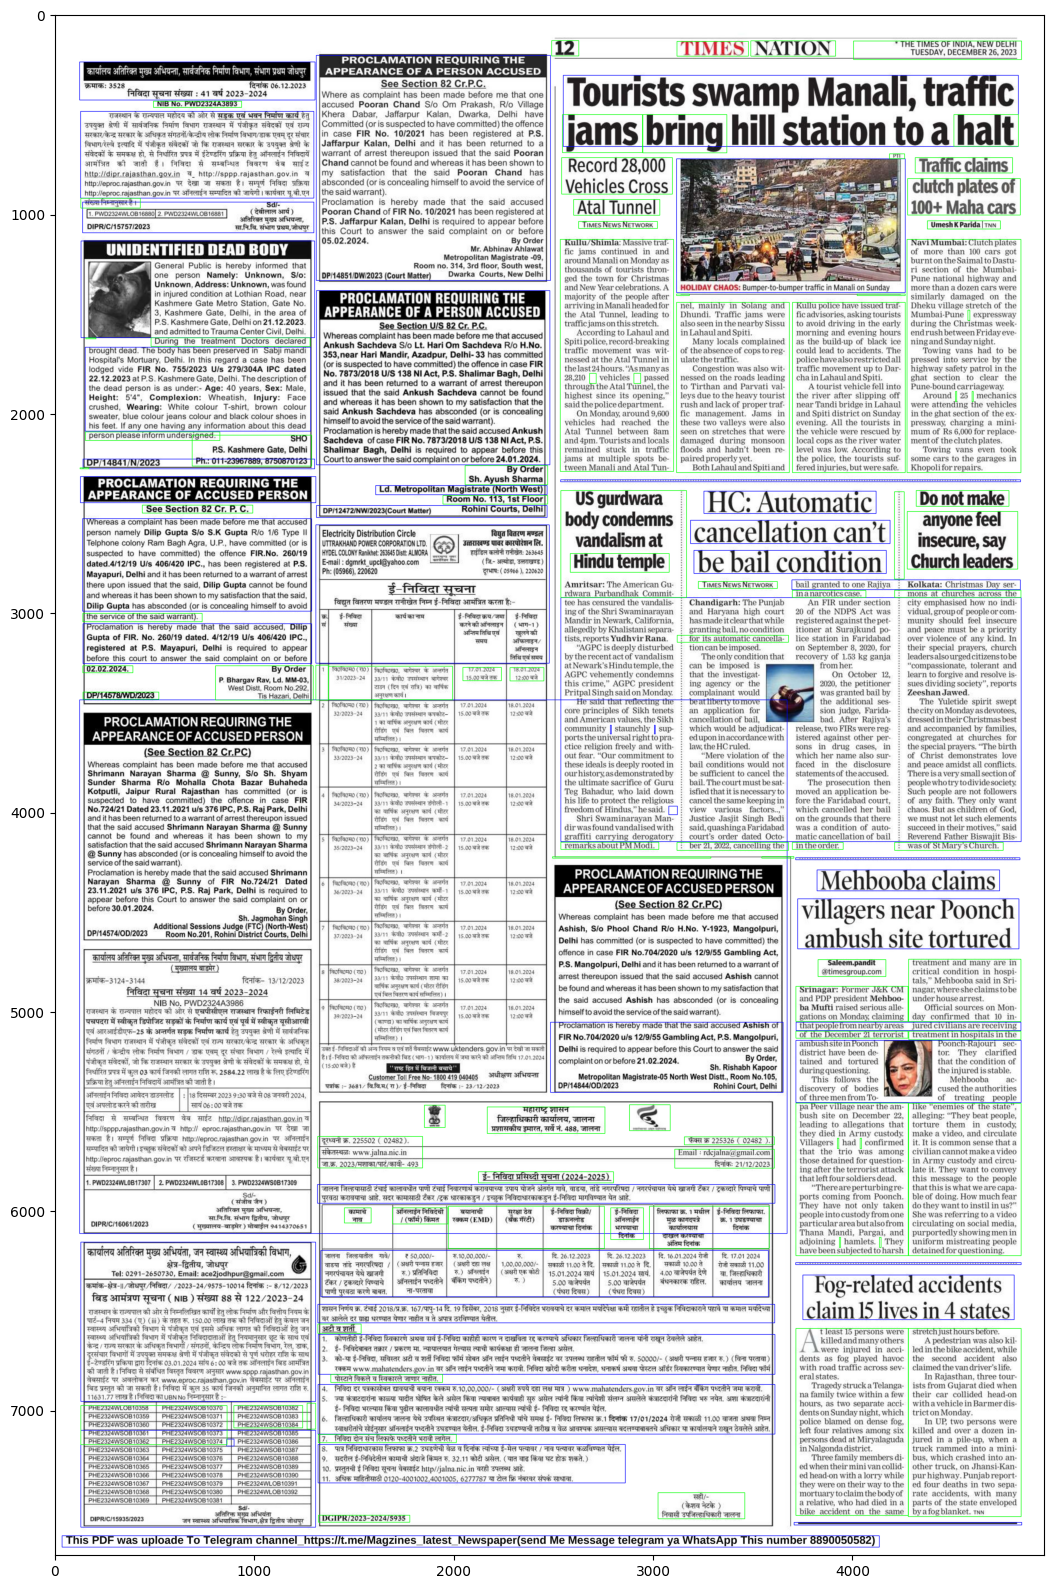

In [15]:
# display the image in large size
plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(image_out, cv2.COLOR_BGR2RGB))